While plenty of time and energy is being actively spent in training large machine learning models, taking these models to production and maintaining them is a task of its own.

# 1. Pain Points of ML Model Deployment

## 1.1. Consistency Challenges

In almost all ML use cases, the algorithm used is typically never coded from scratch. Instead, one uses open-source implementations offered by libraries like PyTorch, Sklearn, and many more.

To ensure reproducibility in production, the production environment should be consistent with the environment it was trained in.

This involves installing similar versions of libraries used, software dependencies, OS configurations, and many more.

Achieving this consistency can, at times, be challenging.

## 1.2. Infrastructural Challenges

ML models typically require specialized processors like GPUs for training.

Depending upon the complexity, a specialized infrastructure may also be needed during inference, i.e., post-deployment.

Setting up these specialized infrastructures is often challenging for data teams.

## 1.3. Inadequate Expertise (or Knowledge Gap)

ML engineers may not have experience with deployment. They may not have the necessary expertise in areas such as software engineering, DevOps, and infrastructure management.

This can make it difficult for them to effectively deploy and scale models in production environments.

In such cases, organizations hire specialized talents.

However, engineers hired specifically for deployment may not have an in-depth understanding of ML algorithms and techniques.

This makes it difficult for them to understand the code and make necessary optimizations, leading to issues with scaling, performance, and reliability, and can ultimately impact the effectiveness of the model in production.

# 2. Deploying ML Models from Jupyter Notebook

The above pain points, to an extent, highlight the necessity for a data scientist to have the necessary deployment expertise.

Now, data scientists spend most of their time working in a Jupyter notebook.

Thus, to simplify the deployment process and integrate it with Jupyter to create a model endpoint, I will use the [Modelbit](https://www.modelbit.com/) API.

## 2.1. Workflow

<img src="images/1_e6nuyyak964yLYYq1tG5RA.webp" style="width:800px;height:500px;background-color:white">

First, inside a jupyter notebook, we will train a machine learning model.

Next, we’ll create a prediction function, which will accept the input as its parameters and return the model’s prediction.

After that, we’ll gather the list of packages used along with their version and the python version we trained our model in. This info, along with the function object will be sent for deployment.

Finally, we will retrieve the model endpoint.

### Preparation of Dummy Dataset

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

In [2]:
X, y = make_regression(n_samples=200, n_features=1, noise=20, random_state=123)

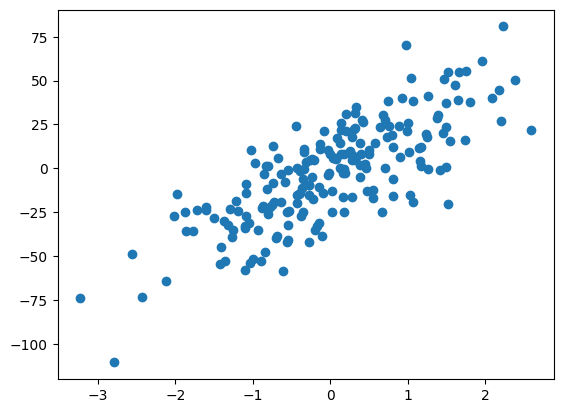

In [3]:
plt.figure()
plt.scatter(X, y)
plt.show();

### Step 1: Training the Machine Learning Model

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [6]:
y_pred = model.predict(X)

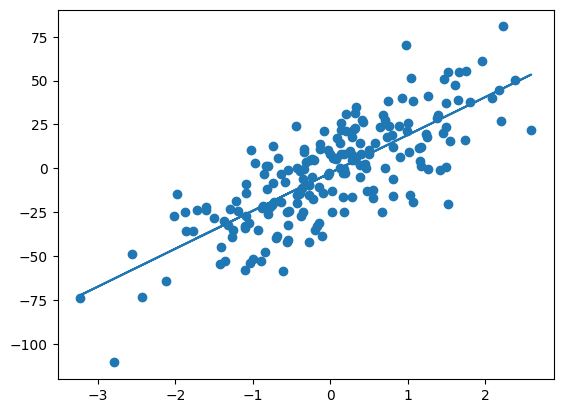

In [7]:
plt.figure()
plt.scatter(X, y)
plt.plot(X, y_pred)
plt.show();

### Step 2: Setup Modelbit

In [8]:
import modelbit

In [9]:
mb = modelbit.login()

### Step 3: Deploy Models

To deploy the model using Modelbit, we should set up a python function to ensure seamless deployment and inference post-deployment.

Essentially, this function will contain the code that will be executed at runtime, and it will be responsible to return the prediction.

We should specify the input parameters as needed by the model in this method. Also, you can name it anything you want.

Let’s create a `my_lr_deployement()` method.

In [10]:
def my_lr_deployement(input_x):
    if isinstance(input_x, (int, float)):  # check input type
        return model.predict([[input_x]])[0]  # prediction

    else:
        return None

**Note**: Every dependency of the function (`model` in this case) is pickled and sent to production automatically along with the function. Thus, you are free to reference anything in this method.

To deploy, run the following commands:

In [11]:
mb.deploy(my_lr_deployement)

In [12]:
### Original Format for Single Input
# curl -X POST "https://johnlee.app.modelbit.com/v1/my_lr_deployement/latest" -d "{\"data\": input_x}"

!curl -X POST "https://johnlee.app.modelbit.com/v1/my_lr_deployement/latest" -d "{\"data\": -3}"

{"data": -67.32734182682607}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    40  100    28  100    12     32     13 --:--:-- --:--:-- --:--:--    46


In [13]:
# To check on local
my_lr_deployement(-3)

-67.32734182682607

In [14]:
### Original Format for Batch Input

# The first number in the list (1) is the input ID.
# The ID can be any identifier that you prefer to use.
# The numbers following the ID are the function parameters.

# curl -X POST "https://johnlee.app.modelbit.com/v1/my_lr_deployement/latest" -d "{\"data\": [[1, input_x], [2, input_x]]}"

!curl -X POST "https://johnlee.app.modelbit.com/v1/my_lr_deployement/latest" -d "{\"data\": [[1, -3], [2, 0], [3, 2]]}"

{"data": [[1, -67.32734182682607], [2, -2.6246990978694162], [3, 40.51039605476836]]}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    35    0     0  100    35      0     47 --:--:-- --:--:-- --:--:--    47
100   120  100    85  100    35    107     44 --:--:-- --:--:-- --:--:--   151


Invoking the deployed model is not just limited to `curl`. We can also use the `requests` library in python:

In [15]:
import json

import requests

In [16]:
requests.post(
    "https://johnlee.app.modelbit.com/v1/my_lr_deployement/latest",
    headers={"Content-Type": "application/json"},
    data=json.dumps({"data": [[1, -3], [2, 0], [3, 2]]}),
).json()

{'data': [[1, -67.32734182682607],
  [2, -2.6246990978694162],
  [3, 40.51039605476836]]}

## 2.2. Custom Environments

Sometimes we may want to specify specific versions of the libraries used while deploying your model.

We can pass these as an argument to the `md.deploy()` method call:

In [17]:
# mb.deploy(my_lr_deployement, python_packages=["scikit-learn==1.1.2", "pandas==1.5.0"])

We can also deploy to a specific version of Python:

In [18]:
# mb.deploy(my_lr_deployement, python_version="3.9")